In [31]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils
import graphviz
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import ast

In [32]:
FILE_NAME = "test"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("../dataset_perso/Lawsuit.csv")
del df['ID']

salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)

for i in range(0,len(df)):
    df.at[i, "Gender"] = 0 if df.at[i, "Gender"] == 1 else 1
    X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]

y = df['Salary_mean']
sensitive = df['Gender']
print(utils.discrimination(y, sensitive))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

0.31205112598904444


In [33]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=5, error_function=lambda tids: utils.error(list(tids), 200, y_train, sensitive_train), min_sup=2, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

print(f'sum discrimination_pred  = {round(sum_discrimination_additive_train_pred, 8)}')
print(f'sum discrimination_pred abs = {round(sum_discrimination_additive_train_pred_abs, 8)}')

utils.perf_measure(y_train, y_pred_train, sensitive_train)

accuracy_pred = 0.79904306
accuracy_test = 0.73076923
discrimination_train = 0.32561905
discrimination_train_pred = 0.06761905
sum discrimination_pred  = 0.06761905
sum discrimination_pred abs = 0.06761905


((56, 9, 50, 10), (16, 22, 45, 1))

In [34]:
import relabeling_pydl
leafs = list()
cnt_unique = np.unique(sensitive_train, return_counts=True)[1]

leafs_relab = relabeling_pydl.relab(clf.tree_, y_train, y_pred_train, sensitive_train, 0.0)
sum_acc = 0
sum_disc = 0

for leaf in leafs_relab:
    relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)

y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

print(f'sum discrimination_pred  = {round(sum_discrimination_additive_train_pred, 8)}')
print(f'sum discrimination_pred abs = {round(sum_discrimination_additive_train_pred_abs, 8)}')
utils.perf_measure(y_train, y_pred_train, sensitive_train)

accuracy_pred = 0.6937799
accuracy_test = 0.63461538
discrimination_train = 0.32561905
discrimination_train_pred = -0.03228571
sum discrimination_pred  = -0.03228571
sum discrimination_pred abs = 0.09419048


((43, 11, 48, 23), (13, 26, 41, 4))

In [35]:
_COLORS = ['#8b4513', '#006400', '#4682b4', '#4b0082', '#ff0000', '#00ff7f', '#00ffff', '#0000ff', '#ffff54',
           '#ff1493', '#ffe4c4']
import statistics

def round_down(a, exp=3):
    dec = 10**exp
    return round(a * dec)/float(dec)

def plot_graph_confusion(r):
    plt.figure(figsize=(9, 6))
    # style = ['solid', 'dotted', ':', '-.', 'dashed']
    style = ['solid', '–', '—', '-.', ':', '.', 'o', ',', 'v', '^']
    colors = _COLORS.copy()
    fig, ax = plt.subplots()
    for k in [0, 5, 10, 50, 100, 150, 200, 250, 500, 1000, 100000]:
        TP0s_list, FP0s_list, TN0s_list, FN0s_list = [], [], [], []
        TP1s_list, FP1s_list, TN1s_list, FN1s_list = [], [], [], []
        for depth in r['depth'].unique():
            
            df1 = r.loc[(r["k"] == k) & (r["depth"] == depth)]
            
            TP0s, FP0s, TN0s, FN0s = [], [], [], []
            TP1s, FP1s, TN1s, FN1s = [], [], [], []
            for index, row in df1.iterrows():
                conf = df1.at[index, 'confusion']
                conf = res = eval(conf)
                TP0s.append(conf[0][0])
                FP0s.append(conf[0][1])
                TN0s.append(conf[0][2])
                FN0s.append(conf[0][3])
                
                TP1s.append(conf[1][0])
                FP1s.append(conf[1][1])
                TN1s.append(conf[1][2])
                FN1s.append(conf[1][3])
            
            TP0s_list.append(round_down(statistics.mean(TP0s)))
            FP0s_list.append(round_down(statistics.mean(FP0s)))
            TN0s_list.append(round_down(statistics.mean(TN0s)))
            FN0s_list.append(round_down(statistics.mean(FN0s)))
            
            TP1s_list.append(round_down(statistics.mean(TP1s)))
            FP1s_list.append(round_down(statistics.mean(FP1s)))
            TN1s_list.append(round_down(statistics.mean(TN1s)))
            FN1s_list.append(round_down(statistics.mean(FN1s)))
                
        plt.plot(r['depth'].unique(), TP0s_list, label="TP0", color=colors[0], linestyle=style[0])
        plt.plot(r['depth'].unique(), FP0s_list, label="FP0", color=colors[1], linestyle=style[0])
        plt.plot(r['depth'].unique(), TN0s_list, label="TN0", color=colors[2], linestyle=style[0])
        plt.plot(r['depth'].unique(), FN0s_list, label="FN0", color=colors[3], linestyle=style[0])
        
        plt.plot(r['depth'].unique(), TP1s_list, label="TP1", color=colors[0], linestyle=style[3])
        plt.plot(r['depth'].unique(), FP1s_list, label="FP1", color=colors[1], linestyle=style[3])
        plt.plot(r['depth'].unique(), TN1s_list, label="TN1", color=colors[2], linestyle=style[3])
        plt.plot(r['depth'].unique(), FN1s_list, label="FN1", color=colors[3], linestyle=style[3])
        
        
        print(f'{(TP0s_list[5], FP0s_list[5], TN0s_list[5], FN0s_list[5]), (TP1s_list[5], FP1s_list[5], TN1s_list[5], FN1s_list[5])} {str(k)} ')
    

((61.467, 5.778, 52.644, 3.867), (16.244, 5.289, 61.667, 2.044)) 0 
((60.8, 5.156, 53.267, 4.533), (16.4, 5.4, 61.556, 1.889)) 5 
((60.8, 5.156, 53.267, 4.533), (16.4, 5.4, 61.556, 1.889)) 10 
((59.689, 4.733, 53.689, 5.644), (16.733, 6.311, 60.644, 1.556)) 50 
((59.533, 4.978, 53.444, 5.8), (17.022, 11.511, 55.444, 1.267)) 100 
((55.933, 6.111, 52.311, 9.4), (16.956, 16.289, 50.667, 1.333)) 150 
((53.156, 6.778, 51.644, 12.178), (16.556, 18.133, 48.822, 1.733)) 200 
((49.689, 6.644, 51.778, 15.644), (16.089, 17.711, 49.244, 2.2)) 250 
((46.022, 6.578, 51.844, 19.311), (15.556, 17.111, 49.844, 2.733)) 500 
((43.178, 6.422, 52.0, 22.156), (14.933, 16.244, 50.711, 3.356)) 1000 
((40.578, 6.111, 52.311, 24.756), (14.333, 15.067, 51.889, 3.956)) 100000 


<Figure size 648x432 with 0 Axes>

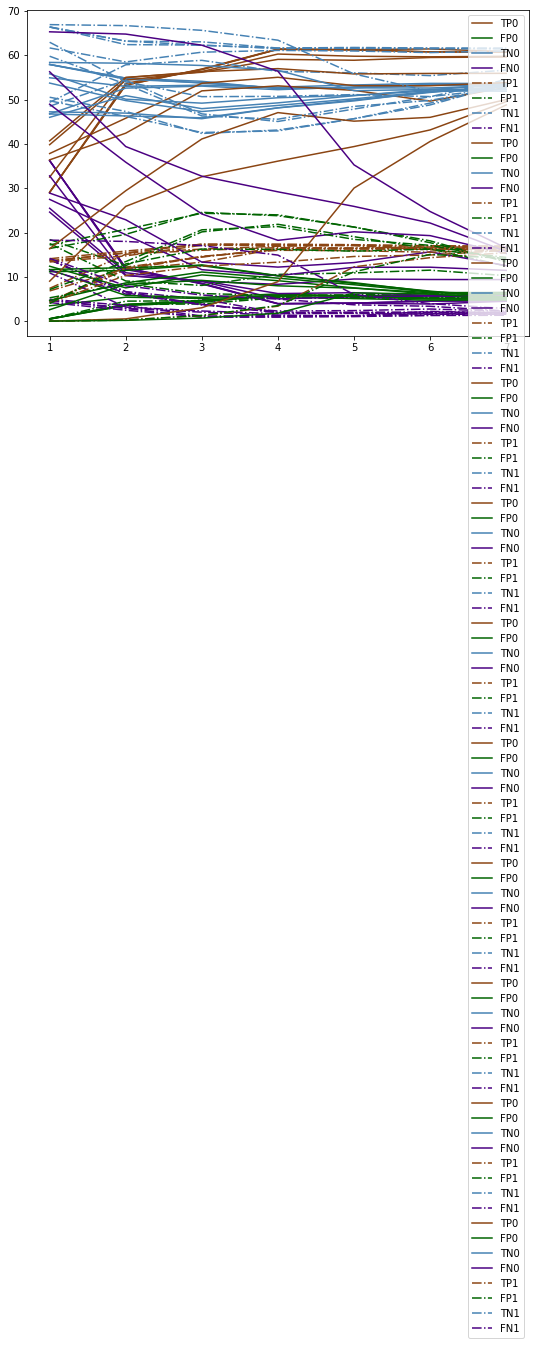

In [36]:
result = pd.read_csv("save/lawsuit_k_supp2.csv")
plot_graph_confusion(result)